Based on code by Tucker Hartland in linear_inversion3D_cylinder.py

In [1]:
from linear_inversion3D_cylinder import *

In [2]:
from make_fenics_amg_solver import make_fenics_amg_solver
from localpsf import *
from localpsf_helpers import *
import hlibpro_wrapper as hpro
import scipy.sparse as sps
import scipy.sparse.linalg as spla

In [3]:
dl.set_log_active(False)
ndim = 3

use_fine_mesh = False
recompute_stuff = False
gauss_newton = False
finite_element_order_p = 1

linear        = False #True # linear or nonlinear forward model 
compression   = False # generate compressions of the Hessian misfit
hodlr         = False
verbose_save  = False
solve_inverse = False # do you want to determine the MAP point or not?
inexact       = True
direc         = './figures/'
if compression and hodlr:
    compression_type = "HODLR"
elif compression and not hodlr:
    compression_type = "LR"
else:
    compression_type = ""

# Reduce order of quadrature
dl.parameters['form_compiler']['quadrature_degree'] = 4

# forcing term
grav = 9.81
rho = 910.0

Length = 1.
Width  = 1.
Height = 1.
# rheology
if linear:
    n = 1
    A_value = 2.140373e-7
else:
    n = 3.0
    A_value = 1.e-16 
A = dl.Constant(A_value)

# Mesh

In [4]:
# boundary and submesh needed for manifold prior
# IMPORTANT ========
if use_fine_mesh:
    mfile_name = "meshes/cylinder3"
else:
    mfile_name = "meshes/cylinder_coarse"
# ==================
mesh = dl.Mesh(mfile_name+".xml")
boundary_markers = dl.MeshFunction("size_t", mesh, mfile_name+"_facet_region.xml")
boundary_mesh = dl.BoundaryMesh(mesh, "exterior", True)
submesh_bottom = dl.SubMesh(boundary_mesh, BasalSub())

mesh

# Mesh manipulation

In [5]:
r0            = 0.05
sig           = 0.4
valleys       = 4
valley_depth  = 0.35
bump_height   = 0.2
min_thickness = 0.08 / 8.
avg_thickness = 0.2 / 8.
theta         = -np.pi/2.
max_thickness = avg_thickness + (avg_thickness - min_thickness) 
A_thickness   = max_thickness - avg_thickness


dilitation = 1.e4
Length *= 2*dilitation
Width  *= 2*dilitation
Radius  = dilitation

coords   = mesh.coordinates()
bcoords  = boundary_mesh.coordinates()
subbcoords = submesh_bottom.coordinates()
coord_sets = [coords, bcoords, subbcoords]
   
def topography(r, t):
    zero = np.zeros(r.shape)
    R0   = r0*np.ones(r.shape)
    return bump_height*np.exp(-(r/sig)**2)*(1.+valley_depth*np.sin(valleys*t-theta)*np.fmax(zero, (r-R0)/sig))

def depth(r, t):
     zero = np.zeros(r.shape)
     R0   = r0*np.ones(r.shape)
     return min_thickness - A_thickness*np.sin(valleys*t-theta)*np.exp(-(r/sig)**2)*np.fmax(zero, (r-R0)/sig)

# note that in order to have nonuniform thickness
# depth will no longer be constant but a function
# of (x,y) 
for k in range(len(coord_sets)): 
    for i in range(len(coord_sets[k])):
        x,y,z = coord_sets[k][i]
        r     = np.sqrt(x**2+y**2)
        t     = np.arctan2(y, x)
        coord_sets[k][i,2] = depth(r,t)*z + topography(r,t)
        coord_sets[k][i] *= dilitation
        
mesh

In [6]:
rank = dl.MPI.rank(mesh.mpi_comm())
nproc = dl.MPI.size(mesh.mpi_comm())

P1  = dl.FiniteElement("Lagrange", mesh.ufl_cell(), finite_element_order_p)
P2  = dl.VectorElement("Lagrange", mesh.ufl_cell(), finite_element_order_p+1)
TH = P2 * P1
Vh2 = dl.FunctionSpace(mesh, TH)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', finite_element_order_p)
Vsub = dl.FunctionSpace(submesh_bottom, 'Lagrange', finite_element_order_p)
Vh = [Vh2, Vh1, Vh2]

ndofs = [Vh[hp.STATE].dim(), Vh[hp.PARAMETER].dim(), Vh[hp.ADJOINT].dim()]
if rank == 0:
    print ("Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(*ndofs))

Number of dofs: STATE=40413, PARAMETER=1830, ADJOINT=40413


# Make flatened 2D basal mesh

Text(0.5, 1.0, 'flattened basal mesh')

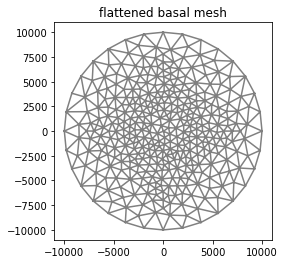

In [7]:
basal_mesh = dl.Mesh()
editor = dl.MeshEditor()
editor.open(basal_mesh, "triangle", 2, 2)

basal_verts = submesh_bottom.coordinates()[:,:2]
basal_cells = submesh_bottom.cells()
n_vert = basal_verts.shape[0]
n_cell = basal_cells.shape[0]

editor.init_vertices(n_vert)
editor.init_cells(n_cell)

# editor.add_vertex(0, basal_verts[2,:])
# editor.add_vertex(1, basal_verts[1,:])
# editor.add_vertex(2, basal_verts[0,:])

# for k in range(3, n_vert):
#     editor.add_vertex(k, basal_verts[k,:])

for k in range(n_vert):
    editor.add_vertex(k, basal_verts[k,:])


for k in range(n_cell):
    editor.add_cell(k, list(basal_cells[k,:]))
    

editor.close()
dl.plot(basal_mesh)
plt.title('flattened basal mesh')

In [8]:
Vbase = dl.FunctionSpace(basal_mesh, 'Lagrange', finite_element_order_p)

### Determine which d.o.f. nodes in the basal mesh correspond to which d.o.f. nodes in the sub mesh

In [77]:
sub_coords = Vsub.tabulate_dof_coordinates()
base_coords = Vbase.tabulate_dof_coordinates()

base_sort_inds = np.lexsort(base_coords.T)
sub_sort_inds = np.lexsort(sub_coords[:,:2].T)

def sub2base(u_sub):
    u_base = u_sub.copy()
    u_base[base_sort_inds] = u_sub[sub_sort_inds]
    return u_base
    
def base2sub(u_base):
    u_sub = u_base.copy()
    u_sub[sub_sort_inds] = u_base[base_sort_inds]
    return u_sub

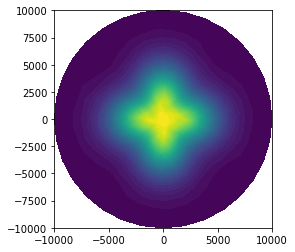

In [10]:
z_expr = dl.Expression('x[2]', domain=mesh, degree=3)
z_sub = dl.interpolate(z_expr, Vsub)

z_base = dl.Function(Vbase)
z_base.vector()[:] = sub2base(z_sub.vector())
dl.plot(z_base)

# SET UP FORWARD MODEL

In [11]:
# Forcing term
f=dl.Constant( ( 0.0, 0.0, -rho*grav) )

# Dirichlet condition.
bc  = []
bc0 = []

# Base Sliding boundary marker
ds = dl.Measure("ds", domain=mesh, subdomain_data=boundary_markers)

normal = dl.FacetNormal(mesh)

# penalty parameter
if linear:
    lam = 1.e14 #1.e18
else:
    lam = 1.e14
# Define the Nonlinear stoke varfs
nonlinearStokesFunctional = NonlinearStokesForm(n, A, normal, ds(1), f, lam)

# Create one-hot vector on pressure dofs
constraint_vec = dl.interpolate( dl.Constant((0,0,0,1)), Vh[hp.STATE]).vector()

pde = EnergyFunctionalPDEVariationalProblem(Vh, nonlinearStokesFunctional, constraint_vec, bc, bc0)
pde.fwd_solver.parameters["rel_tolerance"] = 1.e-8
pde.fwd_solver.parameters["print_level"] = 1
pde.fwd_solver.parameters["LS"]["max_backtracking_iter"] = 10
pde.fwd_solver.solver = dl.PETScLUSolver(method="mumps")

# SET UP PRIOR DISTRIBUTION
Recall from Daon Stadler 2017: The covariance function of the free-space operator has a characteristic length of
$$\sqrt(8(p - d / 2)) \sqrt( \gamma/\delta )$$
meaning that that distance away from a source $x$, the covariance decays to $0.1$ of its maximal value
 - d - dimension of problem
 - A^(-p) - operator, A laplacian-like

In [12]:
gamma=6.e2
rel_correlation_Length = 0.1
correlation_Length = Length*rel_correlation_Length

delta = 4.*gamma/(correlation_Length**2)

m_val1 = 1.e2
m_val2 = 1.e4
prior_mean_val = np.log((m_val1 + m_val2)/2.)

prior_mean = dl.interpolate(dl.Constant(prior_mean_val), Vsub).vector()
priorVsub  = hp.BiLaplacianPrior(Vsub, gamma, delta, mean=prior_mean, robin_bc=False)
prior      = ManifoldPrior(Vh[hp.PARAMETER], Vsub, boundary_mesh, priorVsub)
#Bmatrix = hp.Permutation_matrix(Vh[hp.PARAMETER], Vsub, boundary_mesh,\
#                  save=True,direc="./figures/")
#permut_mat = Bmatrix.kdorderedmatrix([0, 1])
projector_mat = hp.Projector(Vh[hp.PARAMETER], Vsub, boundary_mesh)

# SET UP DATA FIDELITY TERM

Text(0.5, 1.0, 'observation locations')

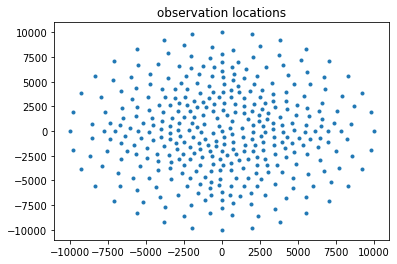

In [13]:
# ntargets equally distributed observation points close to the top boundary
ntargets = len(subbcoords)
targets = np.zeros((ntargets,  ndim), dtype = np.float64)
Xtargets = subbcoords[:ntargets, 0]
Ytargets = subbcoords[:ntargets, 1]

targets[:,:2] = np.array([Xtargets.flatten(), Ytargets.flatten()]).T
for i in range(ntargets):
    x = targets[i, 0] 
    y = targets[i, 1]
    r = np.sqrt(x**2+y**2)/dilitation
    t = np.arctan2(y, x)
    targets[i, 2] = dilitation*(depth(r,t)*0.999999 + topography(r,t))
    
plt.scatter(targets[:,0], targets[:,1], marker='.')
# plt.scatter(targets[:,0], targets[:,1], c=targets[:,2], marker='.')
# plt.scatter(targets[:,0], targets[:,1], c=np.sin(1e-8*targets[:,0]), marker='.')
plt.title('observation locations')

# Define ground truth image basal sliding

1830


Text(0.5, 1.0, 'mtrue')

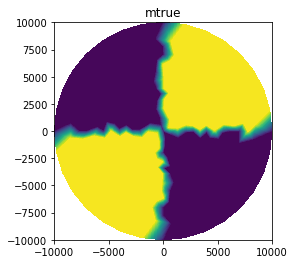

In [14]:
m_func = dl.Expression('std::log(m1 + (m2-m1)*(x[0]*x[1] > 0.))',\
                        element=Vh[hp.PARAMETER].ufl_element(),\
                        m1 = m_val1, m2=m_val2)
#m_func = dl.Expression('std::log(m1 + (m2-m1)*'+\
#                        '((x[0]*x[0]+x[1]*x[1])/(R*R)-r*r)*((x[0]*x[0] + x[1]*x[1])/(R*R)> r*r))',\
#                        element=Vh[hp.PARAMETER].ufl_element(),\
#                        m1= m_val1, m2=m_val2, r=0.5, R=dilitation)                        
mtrue = dl.interpolate(m_func, Vh[hp.PARAMETER]).vector()

mtrue_field = hp.vector2Function(mtrue, Vh[hp.PARAMETER], name="parameter-truth")
print(mtrue_field.function_space().dim())
mtrue_field.set_allow_extrapolation(True)

mtrue_base = dl.Function(Vbase)
mtrue_base.vector()[:] = sub2base(dl.interpolate(mtrue_field, Vsub).vector())
dl.plot(mtrue_base)
plt.title('mtrue')

In [191]:
# mtrue_base.vector()[:]

# Compute the state at ground truth

In [15]:
if use_fine_mesh:
    u_true_filename = "u_true_finemesh.out"
else:
    u_true_filename = "u_true.out"

if recompute_stuff:
    utrue = pde.generate_state()
    pde.solveFwd(utrue, [utrue, mtrue, None])
    utrue_field = hp.vector2Function(utrue, Vh[hp.STATE], name="state-truth")
    dl.File(direc+'u_true.pvd') << utrue_field.sub(0)
    dl.File(direc+'p_true.pvd') << utrue_field.sub(1)
    dl.File(direc+'m_true.pvd') << mtrue_field

    np.savetxt(direc+u_true_filename, utrue.get_local())

In [16]:
utrue = pde.generate_state()
utrue.set_local(np.loadtxt(direc + u_true_filename))

utrue_field = hp.vector2Function(utrue, Vh[hp.STATE], name="state-truth")
mtrue_field = hp.vector2Function(mtrue, Vh[hp.PARAMETER], name="parameter-truth")

# Build noisy observations from ground truth

In [17]:
noise_lvl = 0.01
indicator = dl.interpolate( dl.Constant((1,1,0,0)), Vh[hp.STATE])
component_observed = dl.interpolate( dl.Constant((1,1,0,0)), Vh[hp.STATE]).vector()
uh, vh = dl.TrialFunction(Vh[hp.STATE]), dl.TestFunction(Vh[hp.STATE])
misfit_form = dl.inner(indicator, uh)*dl.inner(indicator, vh)*ds(3)
#misfit = hp.ContinuousStateObservation(Vh[hp.STATE], ds(3), bc, form=misfit_form)
misfit = PointwiseProjectedStateObservation(Vh[hp.STATE], targets, component_observed)
misfit.B.mult(utrue, misfit.d)

#misfit.d.set_local(utrue.get_local())
noise_std_dev = misfit.d.norm("linf")*noise_lvl
hp.parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev
# ==== Define the model ====
model = hp.Model(pde, prior, misfit)

# Map Point reconstruction

In [18]:
if use_fine_mesh:
    u0_filename = "u0_finemesh.out"
else:
    u0_filename = "u0.out"

if recompute_stuff:
    m = prior.mean.copy()
    u0 = pde.generate_state()
    pde.solveFwd(u0, [u0, m, None])
    u0_field = hp.vector2Function(u0, Vh[hp.STATE], name="initial field")
    m0_field = hp.vector2Function(m, Vh[hp.PARAMETER], name="initial parameter")

    dl.File(direc+'u0.pvd') << u0_field.sub(0)
    dl.File(direc+'p0.pvd') << u0_field.sub(1)
    dl.File(direc+'m0.pvd') << m0_field
    
    np.savetxt(direc+u0_filename, u0.get_local())

In [19]:
m = prior.mean.copy()
u0 = pde.generate_state()
u0.set_local(np.loadtxt(direc + u0_filename))

u0_field = hp.vector2Function(u0, Vh[hp.STATE], name="initial field")
m0_field = hp.vector2Function(m, Vh[hp.PARAMETER], name="initial parameter")

In [20]:
parameters = hp.ReducedSpaceNewtonCG_ParameterList()
parameters["print_level"] = 1 
parameters["rel_tolerance"] = 1e-8
parameters["abs_tolerance"] = 1e-12
parameters["max_iter"]      = 40
parameters["cg_max_iter"]   = 150
parameters["globalization"] = "LS"
parameters["GN_iter"] = parameters["max_iter"] + 1
parameters["cg_coarse_tolerance"] = 0.5
if inexact:
    parameters["cg_coarse_tolerance"] = 0.5
else:       
    parameters["cg_coarse_tolerance"] = 1.e-12

if rank != 0:
    parameters["print_level"] = -1

print(parameters.showMe())

 ---
 GN_iter (41): Number of Gauss Newton iterations before switching to Newton
 ---
 LS (ParameterList): Sublist containing LS globalization parameters
     ---
     c_armijo (0.0001): Armijo constant for sufficient reduction
     ---
     max_backtracking_iter (10): Maximum number of backtracking iterations
     ---
 ---
 TR (ParameterList): Sublist containing TR globalization parameters
     ---
     eta (0.05): Reject step if (actual reduction)/(predicted reduction) < eta
     ---
 ---
 abs_tolerance (1e-12): we converge when sqrt(g,g) <= abs_tolerance
 ---
 cg_coarse_tolerance (0.5): Coarsest tolerance for the CG method (Eisenstat-Walker)
 ---
 cg_max_iter (150): Maximum CG iterations
 ---
 gdm_tolerance (1e-18): we converge when (g,dm) <= gdm_tolerance
 ---
 globalization (LS): Globalization technique: line search (LS)  or trust region (TR)
 ---
 max_iter (40): maximum number of iterations
 ---
 print_level (1): Control verbosity of printing screen
 ---
 rel_tolerance (1e-08): w

In [21]:
if solve_inverse:
    solver = hp.ReducedSpaceNewtonCG(model, parameters)
    x = solver.solve([None, m, None])

    state_reconstruction = hp.vector2Function(x[hp.STATE], Vh[hp.STATE], name="state-reconstruction")
    parameter_reconstruction = hp.vector2Function(x[hp.PARAMETER], Vh[hp.PARAMETER], name="parameter-reconstruction")
    dl.File(direc+"u_reconstruction.pvd") << state_reconstruction.sub(0)
    dl.File(direc+"p_reconstruction.pvd") << state_reconstruction.sub(1)
    dl.File(direc+"m_reconstruction.pvd") << parameter_reconstruction

    dl.File(direc+"expm_reconstruction.pvd") << \
         dl.interpolate(dl.Expression("std::exp(m_r)", \
         element = Vh[hp.PARAMETER].ufl_element(), m_r = parameter_reconstruction),\
         Vh[hp.PARAMETER])
    dl.File(direc+"expm_true.pvd") << \
         dl.interpolate(dl.Expression("std::exp(m_t)", \
         element = Vh[hp.PARAMETER].ufl_element(), m_t = mtrue_field),\
         Vh[hp.PARAMETER])
    dl.File(direc+"expm0.pvd") << \
         dl.interpolate(dl.Expression("std::exp(m0)", \
         element = Vh[hp.PARAMETER].ufl_element(), m0 = m0_field),\
         Vh[hp.PARAMETER])


    if rank == 0:
        if solver.converged:
            print( "\nConverged in ", solver.it, " iterations.")
        else:
            print( "\nNot Converged")

        print ("Termination reason: ", solver.termination_reasons[solver.reason])
        print ("Final gradient norm: ", solver.final_grad_norm)
        print ("Final cost: ", solver.final_cost)
        
    # ==== save MAP point data
    np.savetxt(direc+"param.out", x[hp.PARAMETER].get_local())
    np.savetxt(direc+"state.out", x[hp.STATE].get_local())
    np.savetxt(direc+"adjoint.out", x[hp.ADJOINT].get_local())

# Load the MAP point

Text(0.5, 1.0, 'mmap')

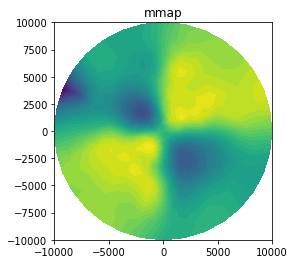

In [22]:
x = model.generate_vector()
if use_fine_mesh:
    x[hp.PARAMETER].set_local(np.loadtxt(direc + "param_finemesh.out"))
    x[hp.STATE].set_local(np.loadtxt(direc + "state_finemesh.out"))
    x[hp.ADJOINT].set_local(np.loadtxt(direc + "adjoint_finemesh.out"))
else:
    x[hp.PARAMETER].set_local(np.loadtxt(direc + "param.out"))
    x[hp.STATE].set_local(np.loadtxt(direc + "state.out"))
    x[hp.ADJOINT].set_local(np.loadtxt(direc + "adjoint.out"))
# this is a vector x[hp.PARAMETER]

mmap = dl.Function(Vh[hp.PARAMETER])
mmap.vector().set_local(x[hp.PARAMETER])

mmap_base = dl.Function(Vbase)
mmap_base.vector()[:] = sub2base(dl.interpolate(mmap, Vsub).vector())
dl.plot(mmap_base)
plt.title('mmap')

/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


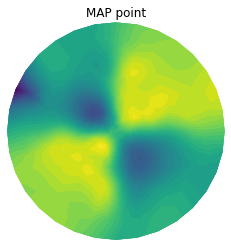

In [192]:
dl.plot(mmap_base, linewidths=0.00000001, antialiased=True, edgecolor="face")
dl.plot(mmap_base, linewidths=0.00000001, antialiased=True, edgecolor="face")
dl.plot(mmap_base, linewidths=0.00000001, antialiased=True, edgecolor="face")
plt.title('MAP point')
plt.axis("off")

plt.savefig("ice_hessian_map_point.pdf",bbox_inches='tight',dpi=100)

## compression data generation 

In [23]:
model.setPointForHessianEvaluations(x, gauss_newton_approx = gauss_newton)
Hmisfit = hp.ReducedHessian(model, misfit_only=True)

# Hessian misfit on the active degrees of freedom
 - $P$ -- a projection matrix
 - $P H P^T$ -- matrix free version of this operator

In [24]:
Hmisfit_proj = hp.proj_op(Hmisfit, projector_mat.P)

vecx_proj = dl.Vector()
vecy_proj = dl.Vector()
vecx = dl.Vector()
vecy = dl.Vector()
Hmisfit_proj.init_vector(vecx_proj, 1)
Hmisfit_proj.init_vector(vecy_proj, 0)
Hmisfit.init_vector(vecx, 1)
Hmisfit.init_vector(vecy, 0)

In [25]:
def apply_H(v_base):
    v_sub = base2sub(v_base)
    Hv_sub = v_sub.copy()
    Hmisfit_proj.mult(v_sub, Hv_sub)
    Hv_base = sub2base(Hv_sub)
    return Hv_base

In [26]:
mass_form = dl.TrialFunction(Vbase) * dl.TestFunction(Vbase) * dl.dx
M = dl.assemble(mass_form)
solve_M = make_fenics_amg_solver(M)

mass_action_form = dl.action(mass_form, dl.Constant(1))
mass_lumps = dl.assemble(mass_action_form)
M_lumped = M.copy()
M_lumped.zero()
M_lumped.set_diagonal(mass_lumps)

inverse_mass_lumps = mass_lumps.copy()
inverse_mass_lumps[:] = 1./mass_lumps[:]
iM_lumped = M_lumped.copy()
iM_lumped.zero()
iM_lumped.set_diagonal(inverse_mass_lumps)

solve_M_lumped = lambda x: iM_lumped * x

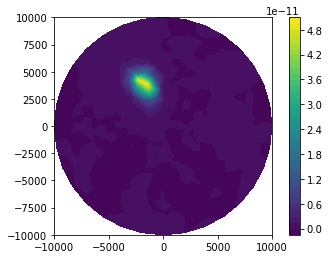

In [103]:
# To fix memory error, I edited ~/anaconda3/envs/fenics2/lib/python3.8/site-packages/hippylib/modeling/PDEProblem.py

ek = dl.Function(Vbase)
ek.vector()[210] = 1.0

uk = dl.Function(Vbase)
uk.vector()[:] = solve_M_lumped(apply_H(solve_M_lumped(ek.vector())))
# uk.vector()[:] = apply_H(ek.vector())
# uk.vector()[:] = solve_M_base2base(apply_H_base2base(solve_M_base2base(ek.vector())))
cm = dl.plot(uk)
plt.colorbar(cm)

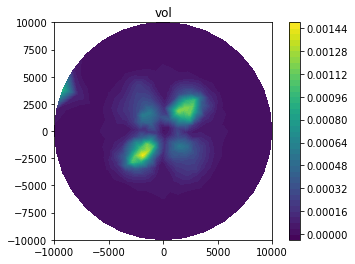

In [28]:
vol = compute_spatially_varying_volume(Vbase, apply_H, solve_M_lumped)
cmap = fenics.plot(vol)
plt.colorbar(cmap)
plt.title('vol')

vol.set_allow_extrapolation(True)

Text(0.5, 1.0, 'mean y-component')

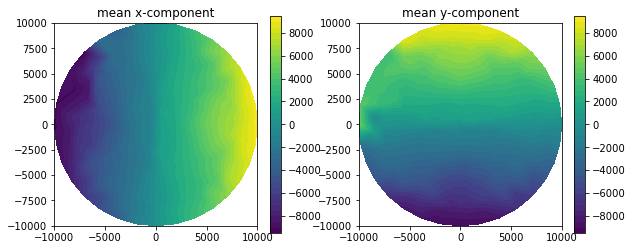

In [29]:
mu = compute_spatially_varying_mean(Vbase, apply_H, solve_M_lumped, vol)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.sca(axes[0])
cmap = fenics.plot(mu.sub(0))
plt.colorbar(cmap)
plt.title('mean x-component')

plt.sca(axes[1])
cmap = fenics.plot(mu.sub(1))
plt.colorbar(cmap)
plt.title('mean y-component')

In [30]:
Sigma = get_spatially_varying_covariance(Vbase, apply_H, solve_M_lumped, vol, mu)

mesh_center = np.array([0.5,0.5])
mesh_radius = 10000
d=2

xx = np.linspace(-0.9*mesh_radius, 0.9*mesh_radius, 6)
yy = np.linspace(-0.9*mesh_radius, 0.9*mesh_radius, 6)

pp = []
for ii in range(len(xx)):
    for jj in range(len(yy)):
        p = np.array([xx[ii], yy[jj]])
        if np.linalg.norm(p - mesh_center) < mesh_radius:
            pp.append(p)

pp = np.array(pp)

Hdd = [get_hessian_dirac_comb_response(pp[k,:].reshape((1,-1)), Vbase, apply_H, solve_M_lumped) for k in range(pp.shape[0])]

/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/f

/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/f

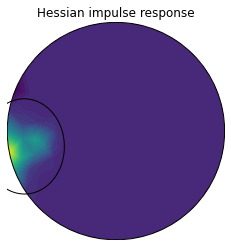

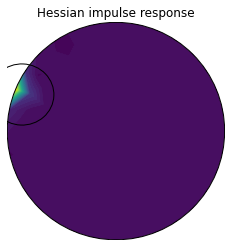

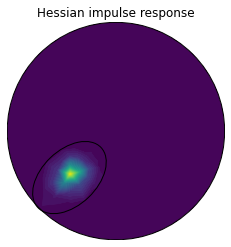

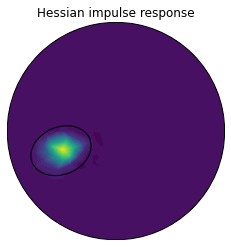

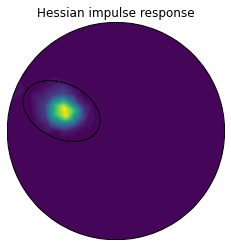

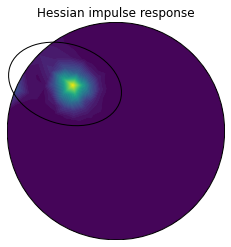

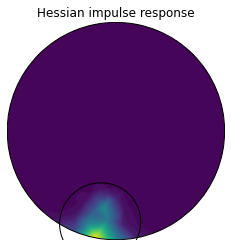

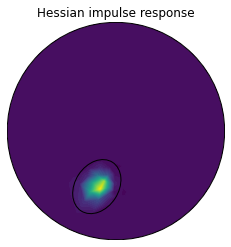

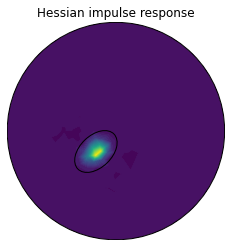

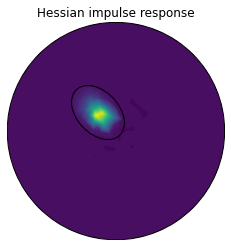

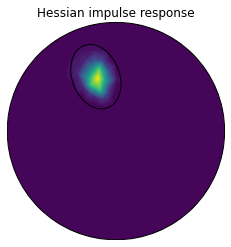

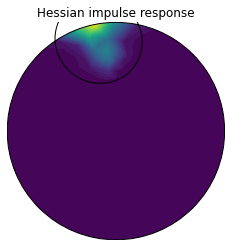

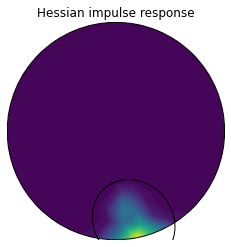

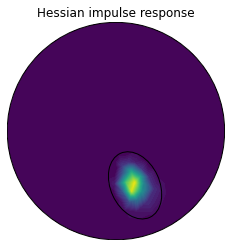

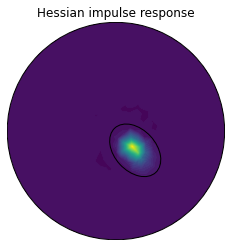

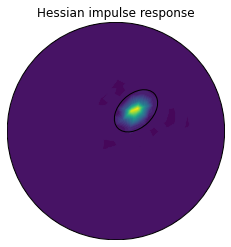

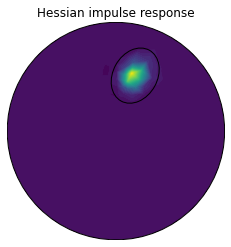

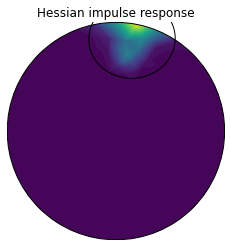

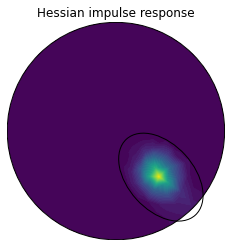

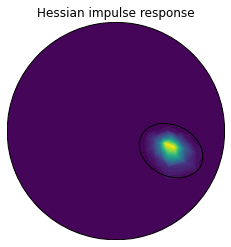

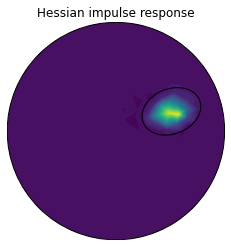

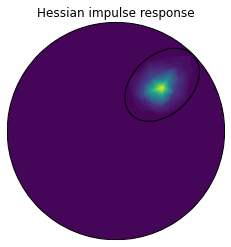

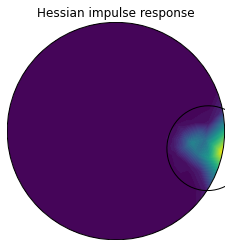

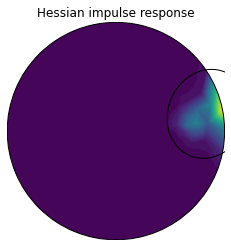

In [149]:
# plt.figure()

# plt.semilogy(krylov_iter_list[:10], errs_reg[:10], linestyle='dotted', color='k')
# plt.semilogy(krylov_iter_list[:10], errs_pre[:10], color='k')

# plt.title('Residual vs. # GMRES iterations',fontsize=14)
# plt.xlabel('Iteration, $k$',fontsize=12)
# plt.ylabel(r'$\frac{||Hx_k - b||}{||b||}$', rotation=0, fontsize=16, labelpad=30)
# plt.legend(['Regularization preconditioner (old)', 'Local PSF preconditioner (new)'])

# plt.savefig("ice_gmres_convergence.pdf",bbox_inches='tight',dpi=100)

Hdd2 = [f.copy() for f in Hdd]
for f in Hdd2:
    f.vector()[:] = f.vector()[:] + 1e-15

# Hdd[0].vector()[:] = Hdd[0].vector()[:] + 1e-15

for k in range(pp.shape[0]):
# for k in range(1):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_ellipse(ax, mesh_center, np.eye(2), mesh_radius)
    
    plt.axis('off')

    cmap = fenics.plot(Hdd2[k], linewidths=0.00000001, antialiased=True, edgecolor="face")
    cmap = fenics.plot(Hdd2[k], linewidths=0.00000001, antialiased=True, edgecolor="face")
    cmap = fenics.plot(Hdd2[k], linewidths=0.00000001, antialiased=True, edgecolor="face")
#     cmap = fenics.plot(Hdd[k], antialiased=True)
#     cmap = fenics.plot(Hdd[k])
#     cmap.set_edgecolor("face")

    plt.title('Hessian impulse response')
#     plt.colorbar(cmap)
    p = pp[k,:]
    mu_p = mu(p)
    C_p = Sigma(p).reshape((d,d))
    plot_ellipse(ax, mu_p, C_p, 3)
    plt.savefig("ice_hessian_impulse_response_" + str(k) + ".pdf",bbox_inches='tight',dpi=100)

Text(0.5, 1.0, 'boundary_indicator')

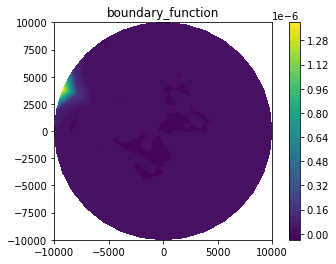

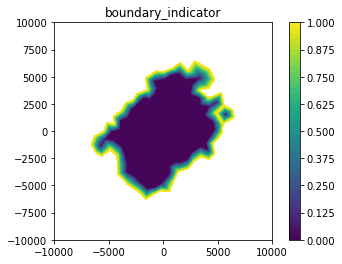

In [32]:
boundary_tol = 1e-11

boundary_function = get_boundary_function(Vbase, apply_H, solve_M_lumped)

cmap = fenics.plot(boundary_function)
plt.colorbar(cmap)
plt.title('boundary_function')

boundary_indicator = fenics.Function(Vbase)
boundary_indicator.vector()[:] = (np.abs(boundary_function.vector()[:]) >= boundary_tol)
boundary_inds = np.where(boundary_indicator.vector()[:])[0]

plt.figure()
cmap = fenics.plot(boundary_indicator)
plt.colorbar(cmap)
plt.title('boundary_indicator')

In [39]:
lpsf = LocalPSF(apply_H, apply_H, Vbase, max_batches=10, boundary_tol=boundary_tol, mass_matrix_M=M_lumped, solve_mass_matrix_M=solve_M_lumped)

getting boundary function
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
constructing fast evaluators
dt_cpp= 0.07639193534851074
dt_py= 0.15038752555847168
done


err_Phi2= 0.1378334659568761


Text(0.5, 1.0, 'Phi_true')

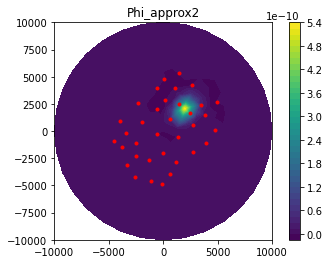

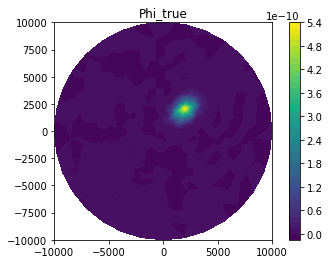

In [106]:
q0 = np.array([[2000,2000]])
qq = np.dot(np.ones((base_coords.shape[0],1)), q0)
# Phi_approx = fenics.Function(V)
# Phi_approx.vector()[:] = BPC.compute_product_convolution_entries(X, qq)

Phi_true = get_hessian_dirac_comb_response(q0, Vbase, apply_H, solve_M_lumped)

Phi_approx2 = fenics.Function(Vbase)
Phi_approx2.vector()[:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(base_coords, qq)

# err_Phi = fenics.norm(Phi_approx.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
# print('err_Phi=', err_Phi)

err_Phi2 = fenics.norm(Phi_approx2.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi2=', err_Phi2)

# cm = fenics.plot(Phi_approx)
# plt.colorbar(cm)
# plt.title('Phi_approx')

# for x in PSI.points:
#     plt.plot(x[0], x[1], '.r')

plt.figure()
cm = fenics.plot(Phi_approx2)
plt.colorbar(cm)
plt.title('Phi_approx2')

for x in lpsf.PSI.points:
    plt.plot(x[0], x[1], '.r')

plt.figure()
cm = fenics.plot(Phi_true)
plt.colorbar(cm)
plt.title('Phi_true')

/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by contourf
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/home/nick/anaconda3/envs/fenics2/lib/python3.8/site-packages/dolfin/common/plotting.py:152: UserWarning: linewidths is ignored by con

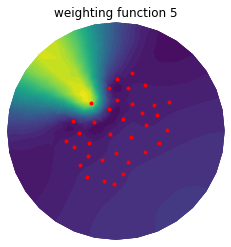

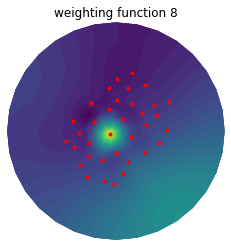

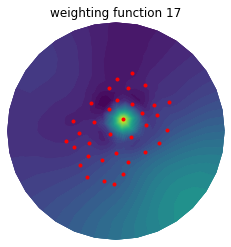

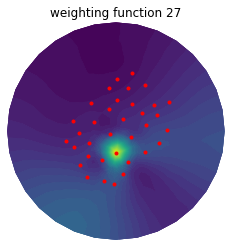

In [156]:
def plot_kth_weighting_function(k):
    fenics.plot(lpsf.PSI.weighting_functions[k], linewidths=0.00000001, antialiased=True, edgecolor="face")
    fenics.plot(lpsf.PSI.weighting_functions[k], linewidths=0.00000001, antialiased=True, edgecolor="face")
    fenics.plot(lpsf.PSI.weighting_functions[k], linewidths=0.00000001, antialiased=True, edgecolor="face")
    for x in lpsf.PSI.points:
        plt.plot(x[0], x[1], '.r')

# for k in range(len(lpsf.PSI.points)):
for k in [5,8,17,27]:
    plt.figure()
    plot_kth_weighting_function(k)
    plt.axis("off")
    plt.title('weighting function '+str(k))
    plt.savefig("ice_hessian_weighting_function_" + str(k) + ".pdf",bbox_inches='tight',dpi=100)

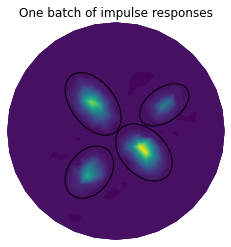

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.axis("off")

b = 1
Hdc = lpsf.dirac_comb_responses[b].copy()
Hdc.vector()[:] = Hdc.vector()[:] + 1e-15
cmap = fenics.plot(Hdc, linewidths=0.00000001, antialiased=True, edgecolor="face")
cmap = fenics.plot(Hdc, linewidths=0.00000001, antialiased=True, edgecolor="face")
cmap = fenics.plot(Hdc, linewidths=0.00000001, antialiased=True, edgecolor="face")
# plt.colorbar(cmap)

plt.title('One batch of impulse responses')

for k in range(lpsf.point_batches[b].shape[0]):
    p = lpsf.point_batches[b][k,:]
    mu_p = lpsf.mu(p)
    C_p = lpsf.Sigma(p).reshape((d,d))
    plot_ellipse(ax, mu_p, C_p, lpsf.tau)
    
plt.savefig("ice_hessian_impulse_response_batch.pdf",bbox_inches='tight',dpi=100)

In [42]:
ct = hpro.build_cluster_tree_from_dof_coords(base_coords, 30)
hpro.visualize_cluster_tree(ct, "ice_sheet_cluster_tree")

bct = hpro.build_block_cluster_tree(ct, ct, 2.0)
hpro.visualize_block_cluster_tree(bct, "ice_sheet_block_cluster_tree")

Hd_hmatrix = lpsf.build_hmatrix(bct, tol=1e-8)

hpro.visualize_hmatrix(Hd_hmatrix, "ice_sheet_hmatrix")

err_hmatvec= 0.7694368678869815


Text(0.5, 1.0, 'error (difference)')

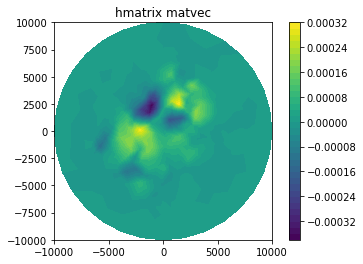

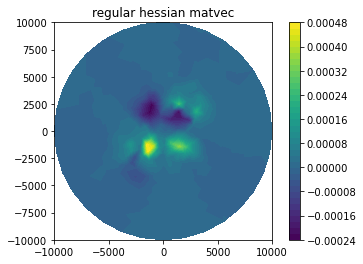

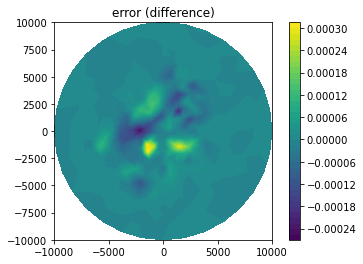

In [45]:
z = fenics.Function(Vbase)
z.vector()[:] = np.random.randn(base_coords.shape[0])
z.vector()[boundary_inds] = 0.0

v = fenics.Function(Vbase)
# v.vector()[:] = hpro.hmatrix_matvec(A_hmatrix, ct, ct, (M * z.vector())[:])
v.vector()[:] = Hd_hmatrix * (M_lumped * z.vector())[:]

v2 = fenics.Function(Vbase)
v2.vector()[:] = iM_lumped * (apply_H(z.vector()))

err_hmatvec = np.linalg.norm(v.vector()[:] - v2.vector()[:])/np.linalg.norm(v2.vector()[:])
print('err_hmatvec=', err_hmatvec)

cm1 = fenics.plot(v)
plt.colorbar(cm1)
plt.title('hmatrix matvec')

plt.figure()
cm2 = fenics.plot(v2)
plt.colorbar(cm2)
plt.title('regular hessian matvec')

plt.figure()
cm3 = fenics.plot(v2 - v)
plt.colorbar(cm3)
plt.title('error (difference)')

In [46]:
def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = fenics.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

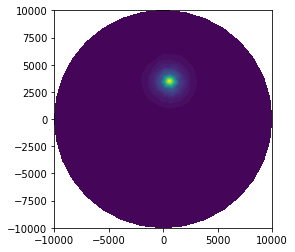

In [85]:
Rsub_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(priorVsub.A)

base_double_sort_inds = np.argsort(base_sort_inds)

ii_s2b = sub_sort_inds[base_double_sort_inds]

Rbase_csc = Rsub_csc[np.ix_(ii_s2b, ii_s2b)]

v = dl.Function(Vbase)
ek = np.zeros(Vbase.dim())
ek[150] = 1.
v.vector()[:] = spla.spsolve(Rbase_csc, ek)

dl.plot(v)

M_lumped_csc = convert_fenics_csr_matrix_to_scipy_csr_matrix(M_lumped)

In [86]:
M_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(M_lumped_csc, bct)
R_hmatrix = hpro.build_hmatrix_from_scipy_sparse_matrix(Rbase_csc, bct)

hpro.visualize_hmatrix(M_hmatrix, "ice_R_hmatrix")

In [87]:
x = np.random.randn(Vbase.dim())
y1 = Rbase_csc * x
y2 = R_hmatrix * x
err_R_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_R_hmatrix=', err_R_hmatrix)

err_R_hmatrix= 1.2976851639246291e-16


In [88]:
x = np.random.randn(Vbase.dim())
y1 = mass_lumps[:] * x
y2 = M_hmatrix * x
err_M_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y1)
print('err_M_hmatrix=', err_M_hmatrix)

err_M_hmatrix= 0.0


In [91]:
def apply_Hfull(x_vec):
    x = fenics.Function(Vbase)
    x.vector()[:] = x_vec
    y_vec = apply_H(x.vector())[:] + Rbase_csc*x_vec
    return y_vec

Hfull_linop = spla.LinearOperator((Vbase.dim(), Vbase.dim()), matvec=apply_Hfull)

In [95]:
Hfull_hmatrix = R_hmatrix + M_hmatrix * (Hd_hmatrix * M_hmatrix)

hpro.visualize_hmatrix(Hfull_hmatrix, "ice_Hfull_hmatrix")

x = np.random.randn(Vbase.dim())
y1 = Hfull_hmatrix * x
y2 = M_lumped_csc * (Hd_hmatrix * (M_lumped_csc * x)) + R_hmatrix * x
err_Hfull_hmatrix = np.linalg.norm(y2-y1)/np.linalg.norm(y2)
print('err_Hfull_hmatrix=', err_Hfull_hmatrix)

err_Hfull_hmatrix= 2.5875258577333286e-16


In [96]:
Hfull_hmatrix_factorized = Hfull_hmatrix.factorized_inverse()

err_H_matrix_factorization = np.linalg.norm(x - Hfull_hmatrix * Hfull_hmatrix_factorized.matvec(x))/np.linalg.norm(x)
print('err_H_matrix_factorization=', err_H_matrix_factorization)

err_H_matrix_factorization= 2.9882060819385485e-12


In [108]:
krylov_iter=5
krylov_tol=1e-12

Hfull_linop = spla.LinearOperator((Vbase.dim(), Vbase.dim()), matvec=apply_Hfull)

solve_R = spla.factorized(R_csc)
solve_R_linop = spla.LinearOperator((Vbase.dim(), Vbase.dim()), matvec=solve_R)

b = np.random.randn(Vbase.dim())

x_R = spla.gmres(Hfull_linop, b, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(apply_Hfull(x_R) - b)/np.linalg.norm(b)
print('err_reg=', err_reg)

x_pre = spla.gmres(Hfull_linop, b, M=Hfull_hmatrix_factorized, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(apply_Hfull(x_pre) - b)/np.linalg.norm(b)
print('err_pre=', err_pre)

err_reg= 0.114449277319682
err_pre= 0.0027784616976739775


# Generate convergence plot

In [110]:
krylov_iter_list=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
krylov_tol=1e-12

errs_reg = list()
errs_pre = list()
for k in range(len(krylov_iter_list)):
    krylov_iter = krylov_iter_list[k]
    Hfull_linop = spla.LinearOperator((Vbase.dim(), Vbase.dim()), matvec=apply_Hfull)

    solve_R = spla.factorized(R_csc)
    solve_R_linop = spla.LinearOperator((Vbase.dim(), Vbase.dim()), matvec=solve_R)

    b = np.random.randn(Vbase.dim())

    x_R = spla.gmres(Hfull_linop, b, M=solve_R_linop, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
    err_reg = np.linalg.norm(apply_Hfull(x_R) - b)/np.linalg.norm(b)
    errs_reg.append(err_reg)

    x_pre = spla.gmres(Hfull_linop, b, M=Hfull_hmatrix_factorized, restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
    err_pre = np.linalg.norm(apply_Hfull(x_pre) - b)/np.linalg.norm(b)
    errs_pre.append(err_pre)
    
    print('k=', k, ', err_reg=', err_reg, ', err_pre=', err_pre)

k= 0 , err_reg= 0.5666571375081587 , err_pre= 0.35305879563778997
k= 1 , err_reg= 0.36798198018676825 , err_pre= 0.05445625952113476
k= 2 , err_reg= 0.2970084216985819 , err_pre= 0.01948231446618808
k= 3 , err_reg= 0.1832208523836968 , err_pre= 0.012231004924619232
k= 4 , err_reg= 0.10411997324559644 , err_pre= 0.0023983389856882956
k= 5 , err_reg= 0.07933268452105302 , err_pre= 0.0005816496875560892
k= 6 , err_reg= 0.04725001060808592 , err_pre= 0.0001210933009846578
k= 7 , err_reg= 0.027765999731598896 , err_pre= 3.356803933421812e-05
k= 8 , err_reg= 0.019759412300509576 , err_pre= 6.711710669776651e-06
k= 9 , err_reg= 0.013694995005572589 , err_pre= 1.4598940022533484e-06
k= 10 , err_reg= 0.009237677591180011 , err_pre= 5.582166893451117e-07
k= 11 , err_reg= 0.004844052202198413 , err_pre= 6.494426357690471e-07
k= 12 , err_reg= 0.0035689072436145843 , err_pre= 2.5688380730680005e-06
k= 13 , err_reg= 0.0019262549639168637 , err_pre= 2.0846741492300777e-06
k= 14 , err_reg= 0.001491606

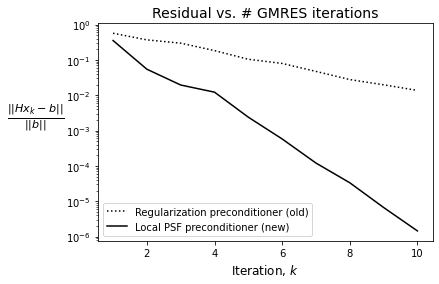

In [121]:
plt.figure()

plt.semilogy(krylov_iter_list[:10], errs_reg[:10], linestyle='dotted', color='k')
plt.semilogy(krylov_iter_list[:10], errs_pre[:10], color='k')

plt.title('Residual vs. # GMRES iterations',fontsize=14)
plt.xlabel('Iteration, $k$',fontsize=12)
plt.ylabel(r'$\frac{||Hx_k - b||}{||b||}$', rotation=0, fontsize=16, labelpad=30)
plt.legend(['Regularization preconditioner (old)', 'Local PSF preconditioner (new)'])

plt.savefig("ice_gmres_convergence.pdf",bbox_inches='tight',dpi=100)

In [193]:
# Hfull_hmatrix_factorized

NameError: name 'batch_points' is not defined

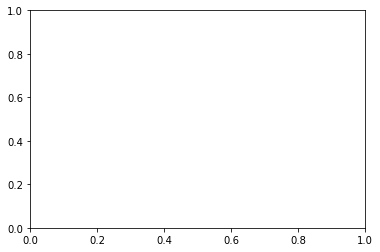

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

Hdc = get_hessian_dirac_comb_response(batch_points, V, apply_H, solve_M_lumped)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)

plt.title('Hessian response 3-sigma support')

for k in range(batch_points.shape[0]):
    p = batch_points[k,:]
    mu_p = mu(p)
    C_p = Sigma(p).reshape((d,d))
    plot_ellipse(ax, mu_p, C_p, num_std_dev_tau)

In [69]:
lpsf.point_batches

[array([[2598.66795646, -532.94326869]]),
 array([[ -187.97372807,   554.47513707],
        [-5555.70233018,  8314.69612303]])]

In [ ]:
samples = 10
ei = np.zeros(vecx_proj.size())
for i in range(samples):
    k = np.random.randint(0, vecx_proj.size()-1)
    ei[k] = 1.0
    vecx_proj.set_local(ei)
    # Applying Hessian to a vector here!
    # y = H x
    Hmisfit_proj.mult(vecx_proj, vecy_proj)
    projector_mat.P.transpmult(vecx_proj, vecx)
    projector_mat.P.transpmult(vecy_proj, vecy)
    x_field = dl.Function(Vh[hp.PARAMETER], vecx)
    Hx_field = dl.Function(Vh[hp.PARAMETER], vecy)

    dl.File(direc+"x_samp_"+str(i)+".pvd") << x_field
    dl.File(direc+"Hx_"+str(i)+".pvd") << Hx_field
    ei[k] = 0.0

In [ ]:
# import ufl

u_trial = dl.TrialFunction(Vsub)
v_test = dl.TestFunction(Vsub)
mass_form = u_trial * v_test * ufl.dx
M = dl.assemble(mass_form)

print(M)

In [ ]:
import scipy.sparse as sps

def convert_fenics_csr_matrix_to_scipy_csr_matrix(A_fenics):
    ai, aj, av = dl.as_backend_type(A_fenics).mat().getValuesCSR()
    A_scipy = sps.csr_matrix((av, aj, ai))
    return A_scipy

In [ ]:
convert_fenics_csr_matrix_to_scipy_csr_matrix(M)

In [ ]:
submesh_bottom.coordinates()

In [ ]:
submesh_bottom.cells().shape

In [ ]:
submesh_bottom.geometric_dimension()

In [ ]:
Vsub.mesh().geometric_dimension()

In [ ]:
gdim = mesh0.geometry().dim()
tdim = mesh0.topology().dim()
c_type = mesh0.type()
c_str = c_type.type2string(c_type.cell_type())

editor.open(mesh, c_str, tdim, gdim)

In [ ]:
submesh_bottom.degree

In [ ]:
basal_topological_dim = 2
basal_geometric_dim = 2
basal_cell_type = submesh_bottom.type()
type(basal_cell_type)

In [ ]:
submesh_bottom.degree()

In [ ]:
x = basal_cell_type.cell_type()
# x = basal_cell_type
type(x)

In [ ]:
basal_cell_type.type2string(x)

In [ ]:
basal_cell_str = basal_cell_type.type2string(basal_cell_type.cell_type())

In [ ]:
editor.close()

In [ ]:
dl.Point(basal_verts[0,:])
l = list(basal_verts[0,:])
type(float(l[0]))
type(k)